# Normal CNN VS ResNET benchmark

#### in this notebook:

the goal is to compare the accuracy difference between a non-residual learning neural network and a ResNET in the Chest X-Ray Images (Pneumonia) by *Paul Mooney*

#### we will:

1. import data

2. build a regular CNN

3. build a Residual-learning-based CNN

4. compare their accuracy and convergence speed

pappers and fonts: `Deep Residual Learning for Image Recognition` (original ResNET papper) & `Understanding Deep Learning` book by *Simon J.D. Prince*

In [2]:
# imports

import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### 1. getting data ready

In [3]:
# getting data into a pytorch dataset class


class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for file_name in os.listdir(cls_dir):
                file_path = os.path.join(cls_dir, file_name)
                self.image_paths.append(file_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224]),
])

train_dataset = CustomImageDataset(root_dir='./data/train', transform=transform)
test_dataset = CustomImageDataset(root_dir='./data/test', transform=transform)

# instanciate dataloader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)



In [4]:
train_dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

### 1.1. EDA (Exploratory Data Analysis)

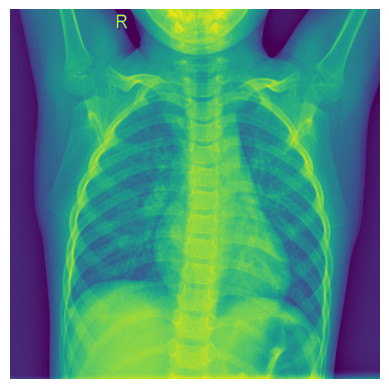

In [5]:
# plot some images

plt.imshow(train_dataset[0][0].permute((1, 2, 0)))
plt.axis(False);

(-0.5, 1023.5, 1023.5, -0.5)

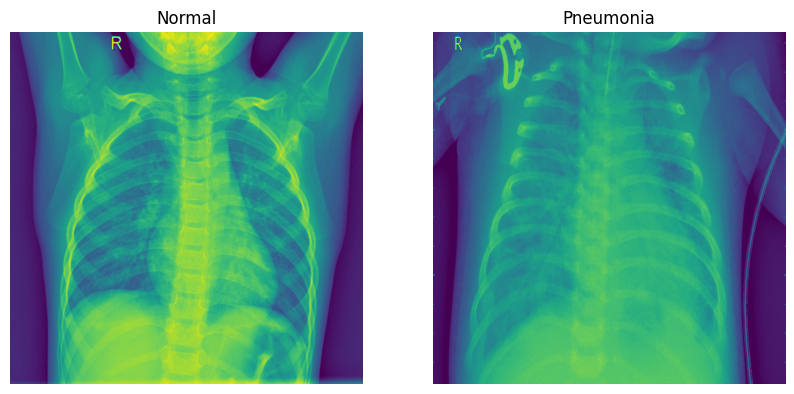

In [6]:
# what is the difference between images of the 2 classes?

# grab normal image
for img, label in train_dataset:
    if label == 0:
        normal = img.permute(1, 2, 0)
        break

for img, label in train_dataset:
    if label == 1:
        pneumonia = img.permute(1, 2, 0)
        break

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(normal)
axes[0].set_title('Normal')
axes[0].axis('off')

axes[1].imshow(pneumonia)
axes[1].set_title('Pneumonia')
axes[1].axis('off')

**Data distribution**

In [7]:
train_normal = len(os.listdir('./data/train/normal'))
test_normal = len(os.listdir('./data/test/normal'))

train_pneumonia = len(os.listdir('./data/train/PNEUMONIA'))
test_pneumonia = len(os.listdir('./data/test/PNEUMONIA'))

len_normal = train_normal + test_normal
len_pneumonia = train_pneumonia + test_pneumonia

print(f"amount of normal label images: {len_normal}")
print(f"amount of pneumonia label images: {len_pneumonia}")



amount of normal label images: 1575
amount of pneumonia label images: 4265


a little bit of class imbalance right there, could use a little bit of **weights in the loss funcion** when training

### 2. building the CNN

we'll build a CNN with 8 layers and **without residual layers and batchnorm**

In [8]:
class CNN(nn.Module):
    def __init__(self): # we won't pass any parameters, it will all be fixed
        super(CNN, self).__init__()

        # convolutions
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3,  padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3,  padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)

        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # fully connected layers
        self.fc1 = nn.Linear(in_features=131072, out_features=2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 2) # final layer

    def forward(self, x):
        # convolution forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # flatten tensor
        x = x.reshape(32, 131072)

        # feed forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # final output
        return x



        

In [9]:
regular_CNN = CNN()
regular_CNN

CNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=2, bias=True)
)

In [10]:
# count up parameters:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"CNN has {count_parameters(regular_CNN)} learnable parameters")


CNN has 269624578 learnable parameters


#### for the next coding time: 

- train and evaluate nromal CNN
- build resnet CNN
- train and evaluate
- build resnet CNN with batchnorm
- train and evaluate


- BONUS: build CNN with double conv and selfattention with residual learning (experiment on different architectures and learning intuition of neural networks)

### 2.1 training regular CNN

In [11]:
op = optim.Adam(params=regular_CNN.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.0, amsgrad=False)
loss_fn = nn.CrossEntropyLoss()

def get_acc(y_true: torch.Tensor, y_pred: torch.Tensor):
    '''
    returns the accuracy of the predictions
    '''
    
    index = 0
    count = 0
    for label in y_pred:
        if label == y_true[index]:
            count += 1
        index += 1
    return (count/len(y_pred))*100

In [12]:
# training loop
EPOCHS = 2

for epoch in range(EPOCHS):
    regular_CNN.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        op.zero_grad()
        outputs = regular_CNN(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        op.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}")

# testing loop
regular_CNN.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = regular_CNN(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy on test set: {round(100 * correct / total, 2)}%")

Epoch 1, Training Loss: 0.2910929315214965
Epoch 2, Training Loss: 0.07860796996877968
Accuracy on test set: 78.45%
